# Yandex Data Science School
## Linear Regression & Regularization Exercise.
### Written by Dr. Hanan Shteingart.

## Outline
In this exercise you will learn the following topics:

1. Refresher on how linear regression is solved in batch and in Gradient Descent 
2. Implementation of Ridge Regression
3. Comparing Ridge, Lasso and vanila Linear Regression on a dataset

## Refresher on Ordinary Least Square (OLS) aka Linear Regeression

### Lecture Note

In Matrix notration, the matrix $X$ is of dimensions $n \times p$ where is each row is an example and each column is a feature dimension. 

Similarily, $y$ is of dimension $n \times 1$ and $w$ is of dimensions $p \times 1$.

The model is $\hat{y}=X\cdot w$ where we assume for simplicity that $X$'s first columns equals to 1 (one padding), to account for the bias term.

Our objective is to optimize the loss $L$ defines as resiudal sum of squares (RSS): 

$L_{RSS}=\frac{1}{N}\left\Vert Xw-y \right\Vert^2$ (notice that in matrix notation this means summing over all examples, so $L$ is scalar.)

To find the optimal $w$ one needs to derive the loss with respect to $w$.

$\frac{\partial{L_{RSS}}}{\partial{w}}=\frac{2}{N}X^T(Xw-y)$ (to see why, read about [matrix derivatives](http://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf) or see class notes )

Thus, the gardient descent solution is $w'=w-\eta \frac{2}{N}X^T(Xw-y)$.

Solving $\frac{\partial{L_{RSS}}}{\partial{w}}=0$ for $w$ one can also get analytical solution:

$w_{OLS}=(X^TX)^{-1}X^Ty$

The first term, $(X^TX)^{-1}X^T$ is also called the pseudo inverse of $X$.

See [lecture note from Stanford](https://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf) for more details.


## Exercise 1 - Ordinary Least Square
* Get the boston housing dataset by using the scikit-learn package. hint: [load_boston](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html)

* What is $p$? what is $n$ in the above notation? hint: [shape](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.shape.html)

* write a model `OrdinaryLinearRegression` which has a propoery $w$ and 3 methods: `fit`, `predict` and `score` (which returns the MSE on a given sample set). Hint: use [numpy.linalg.pinv](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.pinv.html) to be more efficient.

* Fit the model. What is the training MSE?

* Plot a scatter plot where on x-axis plot $Y$ and in the y-axis $\hat{Y}_{OLS}$

* Split the data to 75% train and 25% test 20 times. What is the average MSE now for train and test? Hint: use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) or [ShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html).

* Use a t-test to proove that the MSE for training is significantly smaller than for testing. What is the p-value? Hint: use [scipy.stats.ttest_rel](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_rel.html). 

* Write a new class `OrdinaryLinearRegressionGradientDescent` which inherits from `OrdinaryLinearRegression` and solves the problem using gradinet descent. The class should get as a parameter the learning rate and number of iteration. Plot the class convergance. What is the effect of learning rate? How would you find number of iteration automatically? Note: Gradient Descent does not work well when features are not scaled evenly (why?!). Be sure to normalize your features first.

* **Bonus:** Repeat for coordinate descent by creating a new class `OrdinaryLinearRegressionCoordinateDescent` which also inherits from `OrdinaryLinearRegression`. Compare the learning curves.


In [1124]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
import statistics

from scipy.stats import ttest_rel
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import KFold
from warnings import simplefilter

plt.style.use('fivethirtyeight')

In [1125]:
class OrdinaryLinearRegression:
    
    def _add_bias_clean(self, X):
        X1 = preprocessing.scale(X)
        vector = np.ones((X.shape[0],1)) 
        return np.concatenate((vector, X1), axis=1)
     
    def fit(self, X, y):
        X_with_bias = self._add_bias_clean(X)
        self._W = np.dot(np.linalg.pinv(X_with_bias), y)
        #print("W.shape:{}".format(self._W.shape))
        
    def predict(self, sample):
        sample_with_bias = self._add_bias_clean(sample)
        return np.dot(sample_with_bias, self._W)
    
    def score(self, X, y):
        y_predict = self.predict(X)
        return np.square(y - y_predict).mean()


n:506, p:13
Mse: 21.894831181729202
X.shape:(506, 13), y.shape:(506,), y1.shape:(506,),


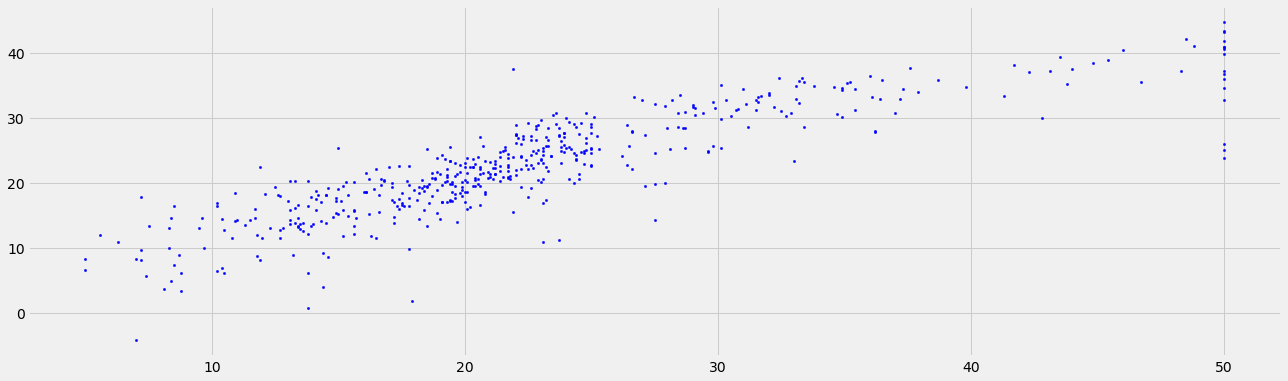

In [1092]:

X, y = load_boston(return_X_y=True)
n, p = X.shape
print("n:{}, p:{}".format(n, p))
    
olr = OrdinaryLinearRegression()
olr.fit(X, y)
y1 = olr.predict(X)

print("Mse: {}".format(olr.score(X, y)))
print("X.shape:{}, y.shape:{}, y1.shape:{},".format(X.shape, y.shape, y1.shape))


fig = plt.figure(figsize=(20,6))
plt.scatter(y, y1, c='b', s=5)

plt.show()

In [1126]:
def average_mse(X, y):
    olr = OrdinaryLinearRegression()
    mse_train = []
    mse_test = []
    for i in range(20):
        train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25) 
        olr.fit(train_X, train_y)
        score = olr.score(train_X, train_y)
        mse_train.append(score)
        score = olr.score(test_X, test_y)
        mse_test.append(score)
    return np.array(mse_train), np.array(mse_test)

In [1127]:
mse_train, mse_test = average_mse(X, y)

print("mean_mse_train:{}, mean_mse_test:{}".format(mse_train.mean(), mse_test.mean()))
(st, pvalue) = ttest_rel(mse_train, mse_test)
print("pvalue:{}".format(pvalue/2)) # it seems totally instable

mean_mse_train:20.830076617287098, mean_mse_test:27.383760332568215
pvalue:0.0007279417088626979


In [1128]:
class OrdinaryLinearRegressionGradientDescent(OrdinaryLinearRegression):

    def __init__(self, learning_rate, num_iterations, iteration_callback=None):
        super().__init__()
        self._epsilon = 0.01
        self._lr = learning_rate
        self._num_iterations = num_iterations
        self._iteration_callback = iteration_callback 
        
    def fit(self, X, y):
        X_clean = self._add_bias_clean(X)
        n, p = X_clean.shape
        self._W = np.random.rand(p)
        old_lost = np.inf
        new_lost = 0
        i = 0
        while i < self._num_iterations:
            self._W -= (2 * self._lr / n) * X_clean.T @ ((X_clean @ self._W) - y)         
            new_lost = np.square(y - X_clean @ self._W).mean()
            if self._iteration_callback is not None:
                self._iteration_callback(new_lost)
            if old_lost - new_lost < self._epsilon:
                print("Not learning anything here. nb iteration:{}".format(i))
                break
            old_lost = new_lost
            i += 1
    
    def predict(self, sample):
        sample_clean = self._add_bias_clean(sample)
        return sample_clean @ self._W


In [1129]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25) 
def save_scores(score):
#     print("addind score:{}".format(score))
    score_list.append(score)


In [904]:
learning_rate = 0.007
num_iterations = 300
score_list = []
olrgd = OrdinaryLinearRegressionGradientDescent(learning_rate, num_iterations, save_scores)
olrgd.fit(train_X, train_y)
#olrgd.predict()
score = olrgd.score(test_X, test_y)
#mse_train.append(score)
print("score on test dataset:{}".format(score))


here cleaning
empty
Not learning anything here. nb iteration:276
here cleaning
empty
score on test dataset:23.089822905612817


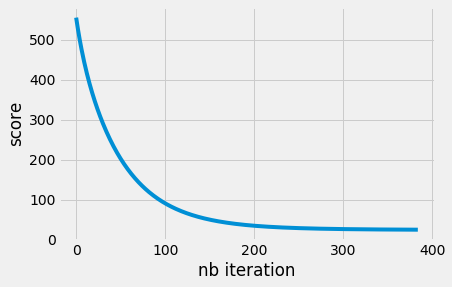

In [981]:
#plot the score
yaxis = score_list
xaxis = np.arange(len(score_list))
plt.xlabel("nb iteration")
plt.ylabel("score")
plt.plot(xaxis, yaxis)

Not learning anything here. nb iteration:278
Not learning anything here. nb iteration:218
Not learning anything here. nb iteration:131
Not learning anything here. nb iteration:71


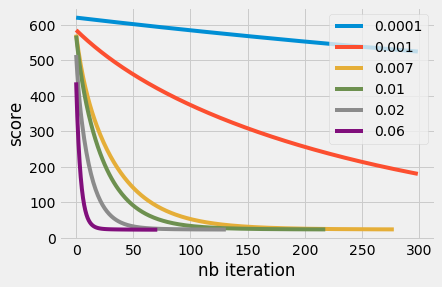

In [982]:
# What is the effect of learning rate?

learning_rate = [0.0001, 0.001, 0.007, 0.01, 0.02, 0.06]
num_iterations = 300
all_score = []
score_list = []
for lr in learning_rate:
    score_list = []
    olrgd = OrdinaryLinearRegressionGradientDescent(lr, num_iterations, save_scores)
    olrgd.fit(train_X, train_y)
    all_score.append(score_list)



for i in range(len(learning_rate)):
    yaxis = all_score[i]
    xaxis = np.arange(len(all_score[i]))
    plt.plot(xaxis, yaxis, label=learning_rate[i])
plt.xlabel("nb iteration")
plt.ylabel("score")
plt.legend()


In [1133]:
class OrdinaryLinearRegressionCoordinateDescent(OrdinaryLinearRegressionGradientDescent):
    
    def __init__(self, learning_rate, num_iterations, save_scores=None):
        super().__init__(learning_rate, num_iterations, save_scores)
    
    def fit(self, X, y):
        intercept = False
        lamda = 0.01
        new_lost = 0
        
        X_clean = self._add_bias_clean(X)
       # X_clean = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
        self._fit_norm = (np.linalg.norm(X_clean,axis = 0))
        X_clean = X_clean / self._fit_norm
        n, nb_feature = X_clean.shape
        self._W = np.random.rand(nb_feature)
        for i in range(self._num_iterations):
            for j in range(nb_feature):
                h = X_clean @ self._W
                gradient = X_clean[:,j] @ (h - y)
                self._W[j] = self._W[j] - self._lr * gradient
            if self._iteration_callback is not None:
                new_lost = np.square(y - X_clean @ self._W).mean()
                self._iteration_callback(new_lost)
                
    def predict(self, sample):
        sample_clean = self._add_bias_clean(sample)
        sample_clean = sample_clean / self._fit_norm #(np.linalg.norm(sample_clean, axis = 0))
        return sample_clean @ self._W

In [1134]:
learning_rate = 0.9
num_iterations = 5
score_list = []
olrcd = OrdinaryLinearRegressionCoordinateDescent(learning_rate, num_iterations, save_scores)
olrcd.fit(train_X, train_y)
#olrgd.predict()
score = olrcd.score(test_X, test_y)
#mse_train.append(score)
print("score on test dataset:{}".format(score))

score on test dataset:27.206413229363157


In [986]:
print("list of score:{}".format(score_list))

list of score:[40.377477972635944, 27.07974071768585, 24.747484042596497, 23.82908181446838, 23.420202186772883]


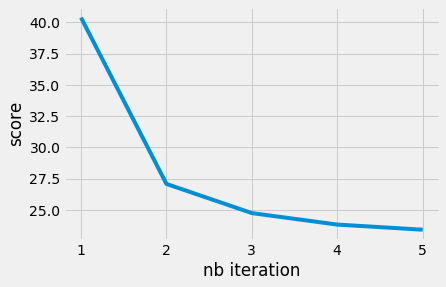

In [987]:
yaxis = score_list
xaxis = np.arange(1, len(score_list) + 1)
plt.xlabel("nb iteration")
plt.ylabel("score")
plt.plot(xaxis, yaxis)

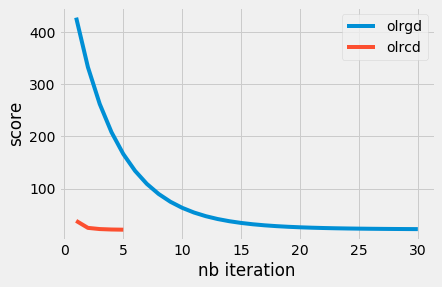

In [1135]:
#Bonus: Repeat for coordinate descent by creating a new class OrdinaryLinearRegressionCoordinateDescent 
#which also inherits from OrdinaryLinearRegression. 
#Compare the learning curves

learning_rate = 0.06
num_iterations = 30

score_list = []

olrgd = OrdinaryLinearRegressionGradientDescent(learning_rate, num_iterations, save_scores)
olrgd.fit(train_X, train_y)
score_list_olrgd = score_list

score_list = []
learning_rate = 0.9
num_iterations = 5
score_list_olrcd = []
olrcd = OrdinaryLinearRegressionCoordinateDescent(learning_rate, num_iterations, save_scores)
olrcd.fit(train_X, train_y)
score_list_olrcd = score_list


yaxis = score_list_olrgd
xaxis = np.arange(1, len(score_list_olrgd) + 1)
plt.xlabel("nb iteration")
plt.ylabel("score")
plt.plot(xaxis, yaxis, label="olrgd")

yaxis = score_list_olrcd
xaxis = np.arange(1, len(score_list_olrcd) + 1)
plt.xlabel("nb iteration")
plt.ylabel("score")
plt.plot(xaxis, yaxis, label="olrcd")

plt.legend()


## Exercise 2 - Ridge Linear Regression

Recall that ridge regression is identical to OLS but with a L2 penalty over the weights:

$L(y,\hat{y})=\frac{1}{N}\sum_{i=1}^{i=N}{(y^{(i)}-\hat{y}^{(i)})^2} + \lambda \left\Vert w \right\Vert_2$

* Show, by differentiating the above loss, that the analytical solution is $w_{Ridge}=(X^TX+\lambda I)^{-1}X^Ty$
* Change `OrdinaryLinearRegression` and `OrdinaryLinearRegressionGradientDescent` classes to work also for ridge regression (do not use the random noise analogy but use the analytical derivation). Either add a parameter, or use inheritance.
* **Bonus: Noise as a regularizer**: Show that OLS (ordinary least square), if one adds multiplicative noise to the features the **average** solution for $W$ is equivalent to Ridge regression. In other words, if $X'= X*G$ where $G$ is an uncorrelated noise with variance $\sigma$ and mean 1, then solving for $X'$ with OLS is like solving Ridge for $X$. What is the interpreation? 



In [1131]:
class RidgeOrdinaryLinearRegression(OrdinaryLinearRegression):
    
    def __init__(self, alpha):
        super().__init__()
        self._alpha = alpha
    
    def fit(self, X, y):
        X_clean = self._add_bias_clean(X)
#         self._fit_norm = np.linalg.norm(X_clean, axis = 0)
#         X_clean = X_clean / self._fit_norm 

        n, p = X_clean.shape
#         l2= self._alpha * np.identity(p)
#         print(l2.shape)
#         print(l2)
        self._W = np.linalg.pinv(X_clean.T @ X_clean + self._alpha * np.identity(p)) @ X_clean.T @ y
        #print(alpha)
#         L = np.diag(np.array([0] + [self._alpha]*(X_clean.shape[1]-1)))
#         print(L.shape)
#         print(L)
        
#         self._W = np.linalg.inv(X_clean.T @ X_clean  + L) @ X_clean.T @ y
        
#     def predict(self, sample):
#         sample_clean = self._add_bias_clean(sample)
#         sample_clean = sample_clean / self._fit_norm #(np.linalg.norm(sample_clean, axis = 0))
#         return sample_clean @ self._W

Mse: 37.425326287563934


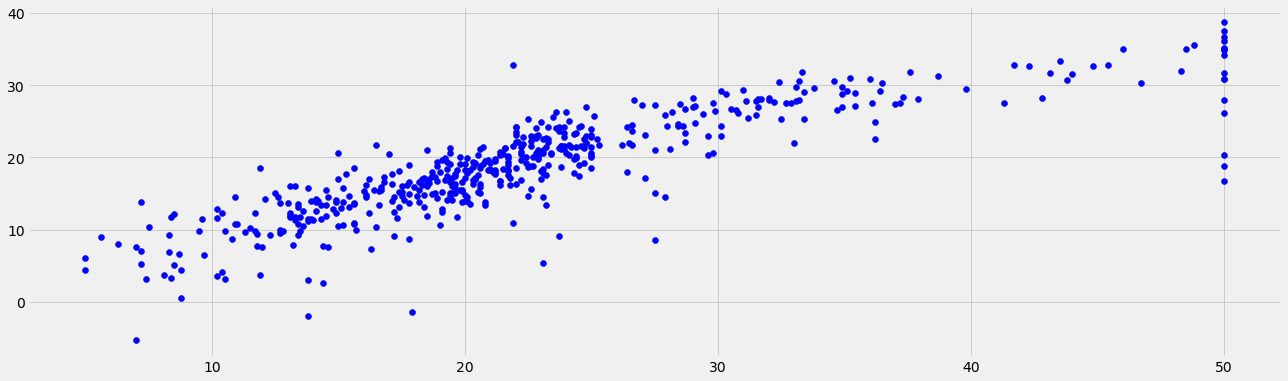

In [1111]:
alpha = 100
rolr = RidgeOrdinaryLinearRegression(alpha)
rolr.fit(X, y)
y1 = rolr.predict(X)

print("Mse: {}".format(rolr.score(X, y)))

fig = plt.figure(figsize=(20,6))
plt.scatter(y, y1, c='b')
plt.show()

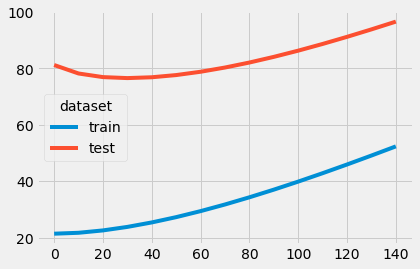

In [1114]:
from warnings import simplefilter
# ignore all future warnings
#simplefilter(action='once', category=UserWarning)
simplefilter(action='ignore', category=UserWarning)

# /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
#   warnings.warn("Numerical issues were encountered "

alpha_list = np.arange(0, 150, 10)

kf = KFold(n_splits=10)
kf.get_n_splits(X)

train_mean = []
test_mean = []
for alpha in alpha_list:
    mse_score_train = []
    mse_score_test = []
    for train_i, val_i in kf.split(X):
        train_X, train_y = X[train_i], y[train_i]
        test_X, test_y = X[val_i], y[val_i]
    #for i in range(10):
        #train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)
        rolr = RidgeOrdinaryLinearRegression(alpha)
        rolr.fit(train_X, train_y)
        mse_score_train.append(rolr.score(train_X, train_y))
#         print(alpha)
        mse_score_test.append(rolr.score(test_X, test_y))
    train_mean.append(np.mean(mse_score_train))
    test_mean.append(np.mean(mse_score_test))
plt.plot(alpha_list, train_mean, label="train")
plt.plot(alpha_list, test_mean, label="test")
plt.legend(title="dataset")
plt.show()

In [1217]:
class  RidgeOrdinaryLinearRegressionGradientDescent(OrdinaryLinearRegressionGradientDescent):
    
    def __init__(self, learning_rate, num_iterations, alpha, iteration_callback=None):
        super().__init__(learning_rate, num_iterations, iteration_callback)
        self._alpha = alpha
        self._epsilon = 0.01
        
    def fit(self, X, y):
        Xc = self._add_bias_clean(X)
        n, p = Xc.shape
        new_lost = 0
        old_lost = np.inf
        self._W = np.random.rand(p)
        for i in range(self._num_iterations):
            l2 = 2 * self._alpha * np.identity(p) @ self._W
            self._W -= (2 * self._lr / n) * (Xc.T @ (Xc @ self._W - y) + l2)
            new_lost = np.square(y - Xc @ self._W).mean()
            if self._iteration_callback is not None:
                self._iteration_callback(new_lost)
            if np.absolute(old_lost - new_lost) < self._epsilon:
                print("Not learning anything here. nb iteration:{}".format(i))
                break
            old_lost = new_lost
            

In [1218]:
learning_rate = 0.005
num_iterations = 1000
alpha = 2
score_list = []

rolrgd = RidgeOrdinaryLinearRegressionGradientDescent(learning_rate, num_iterations, alpha, save_scores)
rolrgd.fit(train_X, train_y)
score = []
for i in range(20):
    score.append(rolrgd.score(test_X, test_y))
#score = rolrgd.score(test_X, test_y) 
#print(score)
print("score average on 20 sample on test dataset:{}".format(np.mean(score)))

Not learning anything here. nb iteration:383
score average on 20 sample on test:28.050556531431038


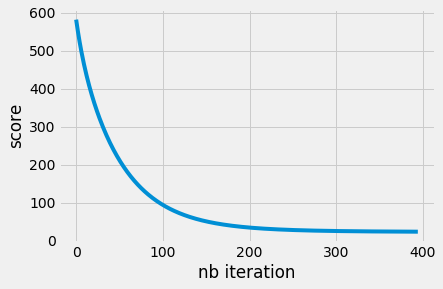

In [1017]:
yaxis = score_list
xaxis = np.arange(len(score_list))
plt.xlabel("nb iteration")
plt.ylabel("score")
plt.plot(xaxis, yaxis)

Not learning anything here. nb iteration:384
score:23.770529160793878


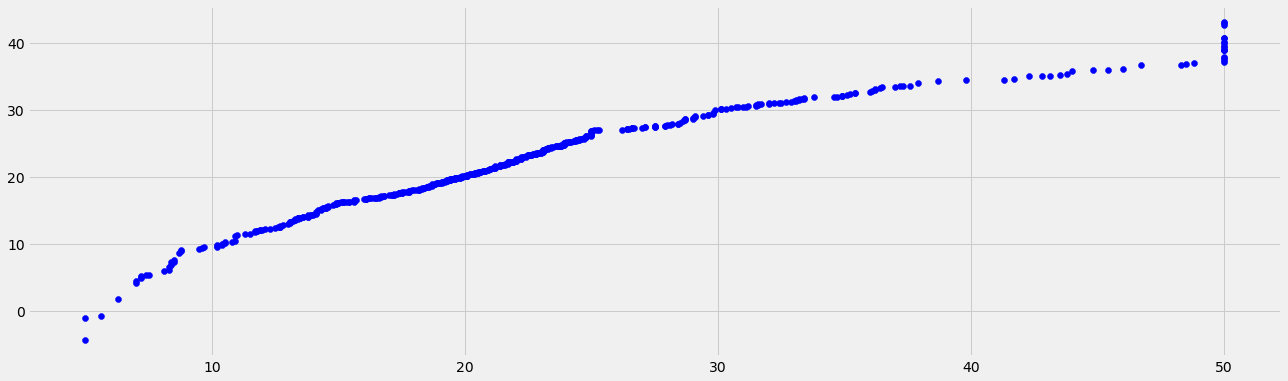

In [1019]:
learning_rate = 0.005
num_iterations = 1000
alpha = 2
score_list = []
rolrgd = RidgeOrdinaryLinearRegressionGradientDescent(learning_rate, num_iterations, alpha, save_scores)
rolrgd.fit(X, y)
y1 = rolrgd.predict(X)
score = rolrgd.score(X, y)
print("score:{}".format(score))


fig = plt.figure(figsize=(20,6))
plt.scatter(np.sort(y), np.sort(y1), c='b')
plt.show()

## Exercise 3 - Lasso Linear Regression

As we've seen in class, Lasso Regression is a regularization technique with $L_1$ penalty on weights. This techniques creates sparse weights (some weights become effectively zero). Programming a Lasso solver is a challange and is left as an optional exercise below.
This exercise will focus on the analysis of the different regularization techniques over a toy problem using the scikit-learn implementation.

### Data generation: 1-D Polynomal Regression
```
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 30
degrees = [1, 4, 15]
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

```

* Use the preprocessing transformer `sklearn.preprocessing.PolynomialFeatures` in order to create a feature space. Note, you can use `sklearn.pipeline.Pipeline` in order to create an effective model which does the preprocessing (not essential).
* Use `sklearn.model_selection.cross_val_score` to evaluate each of the linear model provided by Scikit-learn (`from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV`) and compare the performance over the different `degrees`. To do so, create a 3x3 plot where each row correspond to one model and each column to one degree. Each plot should plot the train data as well as the true model and the fitted one (use 100 points in the range [0,1]) and the CV (cross validation) MSE. What is the take home message? (Note: RidgeCV and LassoCV do an internal cross-validation to determin the regularization parameter.)
* Weights spectrum: change the `alpha` parameter gradually (on a logartithmic scale) and observe how the coefficients change for `degrees=5` over alpha for Ridge and Lasso. What is the take home message?

In [767]:
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 30
degrees = [1, 4, 15]
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1
models = [("olr", LinearRegression()), ("Ridge", RidgeCV()), ("LassoCV", LassoCV(cv=10, tol=0.001, max_iter=10000))]


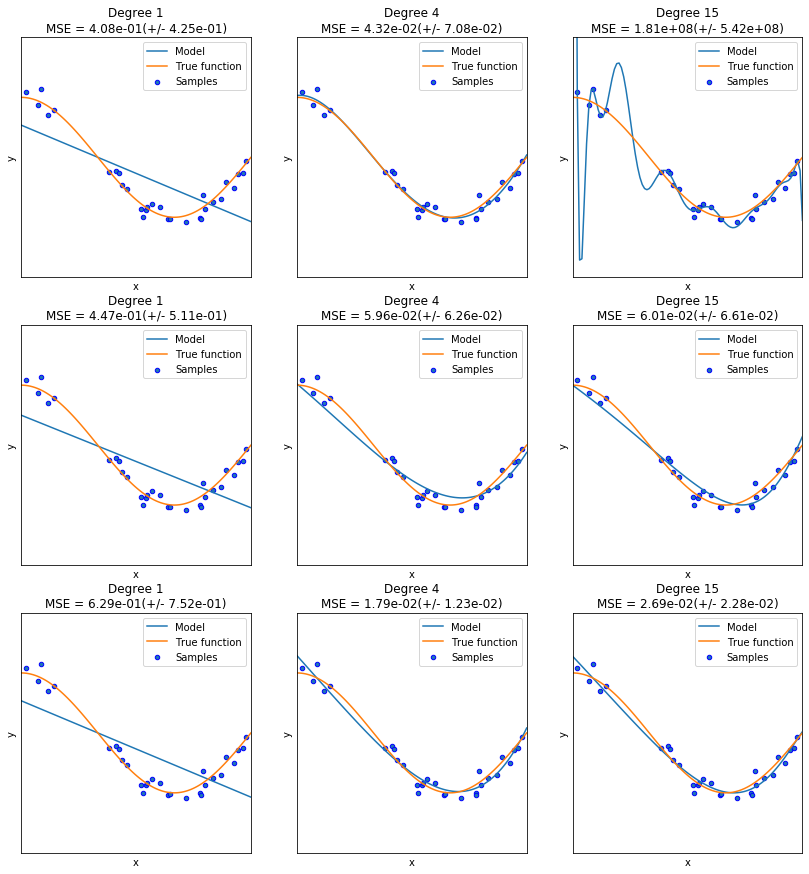

In [768]:

plt.figure(figsize=(14, 15))
#plt.figure()
nb_plt = (model_nb + 1) * len(degrees)
#print("nb_plt:{}".format(nb_plt))
id_plot = 0
for model_nb, model_func in enumerate(models):
    
    for i in range(len(degrees)):
        id_plot += 1
#        print("model_nb:{}".format(model_nb))
        row = model_nb + 1
       # print("id_plot:{}".format(id_plot))
       # print("row:{}, i:{}".format(row, i))
    
        ax = plt.subplot(3, 3, id_plot)
        #ax = plt.subplot(1, len(degrees), i + 1)
        plt.setp(ax, xticks=(), yticks=())

        polynomial_features = PolynomialFeatures(degree=degrees[i],
                                                 include_bias=False)
        pipeline = Pipeline([("polynomial_features", polynomial_features),
                             ( model_func[0], model_func[1])])
        pipeline.fit(X[:, np.newaxis], y)

        # Evaluate the models using crossvalidation
        scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                                 scoring="neg_mean_squared_error", cv=10)

        X_test = np.linspace(0, 1, 100)
        plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
        plt.plot(X_test, true_fun(X_test), label="True function")
        plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xlim((0, 1))
        plt.ylim((-2, 2))
        plt.legend(loc="best")
        plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
            degrees[i], -scores.mean(), scores.std()))
plt.show()